<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Imports
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel

# Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
from explore_data import get_num_words_per_sample 
from explore_data import plot_sample_length_distribution
from explore_data import plot_class_distribution
from explore_data import plot_frequency_distribution_of_ngrams
import seaborn as sns
sns.set()

# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# SKLearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [6]:
# Download spacy model
import spacy
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [7]:
# Read in the data set of Amazon reviews
amazon = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Look at the dataset
amazon.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [8]:
amazon.keys()

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [9]:
amazon['brand'].value_counts()

Amazon          16153
Amazonbasics    12169
AmazonBasics       10
Name: brand, dtype: int64

In [10]:
amazon['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [11]:
amazon['reviews.text'][998]

"Good price but batteries just don't last as long as name brands. My hope was to power Christmas decorations through the holidays and save a few bucks. Many of these batteries did not make it. In the future I will stick with proven brands."

In [12]:
amazon = amazon[['id', 'name', 'primaryCategories', 'reviews.text', 'reviews.rating']]
amazon.head()

,id,name,primaryCategories,reviews.text,reviews.rating
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,I order 3 of them and one of the item is bad q...,3
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Bulk is always the less expensive way to go fo...,4
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Well they are not Duracell but for the price i...,5
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Seem to work as well as name brand batteries a...,5
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,These batteries are very long lasting the pric...,5


In [13]:
# Set option to display max column width
pd.set_option('display.max_colwidth', 0)

# Look at a sample of the training set
amazon.sample(5)

,id,name,primaryCategories,reviews.text,reviews.rating
12135,AVpflnS7ilAPnD_xehxE,AmazonBasics 15.6-Inch Laptop and Tablet Bag,Electronics,"This is a quality product, well constructed with durable materials. Many pockets for laptop accessories or other supplies. Sometimes I use it as just a briefcase and it also serves that purpose well. All in all, it's a great value for a reasonably low price.",5
19728,AVzYlGkFvKc47QAVeZRI,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",Electronics,These were bought as gifts for elementary age kids. It is a great tablet which also gives the kids ability to download books to the Kindle app.,5
20364,AVzYlGkFvKc47QAVeZRI,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",Electronics,I got this tablet because my wife bought the same thing when she upgraded her Kindle. I was shopping all kinds of tablets. But I didn't want to spend big money just to surf my emails and watch video. This does both very well. Super fast with my wi-fi! Great tablet for the money!,5
17948,AVpgdkC8ilAPnD_xsvyi,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",Electronics,"It's a nice upgrade from the 6"" screen. Size is just right for small kids hands. Reading kindle books is much easier.",4
20707,AVzYlGkFvKc47QAVeZRI,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",Electronics,"I got the tablet for $50 but doesn't have the full Android operating system. Even with a software hack, not all the apps from Play Store were usable on this tablet. Returned it and got a Samsung Tablet.",3


In [14]:
# Load the spacy vocab
nlp = spacy.load('en_core_web_lg')

In [15]:
# Create a 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop==False) and (token.is_punct==False):
            lemmas.append(token.lemma_)
    return lemmas

amazon['lemmas'] = amazon['reviews.text'].progress_apply(get_lemmas)

100%|███████████████████████████████████████████████████████████████████████████| 28332/28332 [03:35<00:00, 131.20it/s]


In [16]:
# Look at the first 5 rows to check my work
amazon.head()

,id,name,primaryCategories,reviews.text,reviews.rating,lemmas
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,3,"[order, 3, item, bad, quality, miss, backup, spring, pc, aluminum, battery, work]"
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Bulk is always the less expensive way to go for products like these,4,"[bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Well they are not Duracell but for the price i am happy.,5,"[Duracell, price, happy]"
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Seem to work as well as name brand batteries at a much better price,5,"[work, brand, battery, well, price]"
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,These batteries are very long lasting the price is great.,5,"[battery, long, last, price, great]"


In [17]:
# Create dictionary - Maps a number to a word
id2word = corpora.Dictionary(amazon['lemmas'])

In [18]:
# Look at the amount of words now
len(id2word.keys())

9727

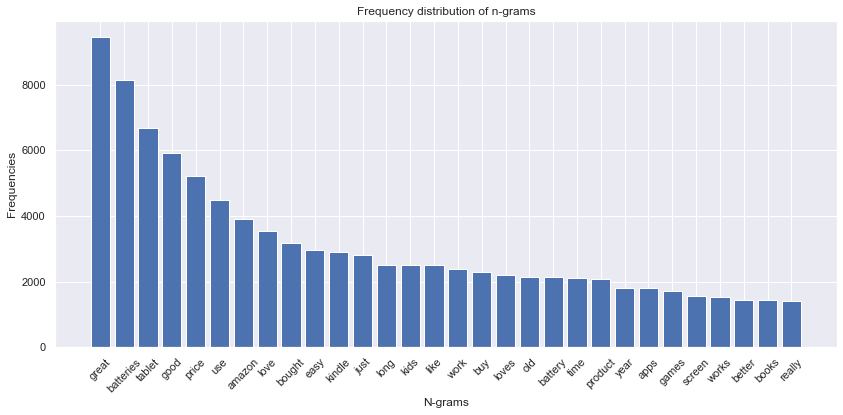

In [19]:
# Look at the count of the top 30 ngrams
plot_frequency_distribution_of_ngrams(amazon['reviews.text'],
                                      ngram_range=(1, 2),
                                      num_ngrams=30)

In [20]:
# Remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.80)

In [21]:
# Look at the amount of words now
len(id2word.keys())

4564

In [22]:
corpus = [id2word.doc2bow(text) for text in amazon['lemmas']]

In [23]:
# Look at a random review
amazon['reviews.text'][33]

'They seem to work okay so far and the price was great.'

In [24]:
# Look at the corpus for the review above
corpus[33]

[(11, 1), (19, 1), (22, 1), (178, 1), (179, 1)]

In [25]:
# Human readable format of the corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[33]]

[('work', 1), ('price', 1), ('great', 1), ('far', 1), ('okay', 1)]

In [26]:
# Train an LDA model
%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

Wall time: 0 ns


In [27]:
lda_model.save('lda_model.model')

In [28]:
lda =  models.LdaModel.load('lda_model.model')

In [29]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.509*"great" + 0.236*"price" + 0.023*"hold" + 0.018*"lot" + 0.017*"Buy" + '
  '0.016*"high" + 0.015*"point" + 0.013*"tell" + 0.011*"grandkid" + '
  '0.010*"hope"'),
 (1,
  '0.181*"tablet" + 0.050*"app" + 0.048*"read" + 0.045*"purchase" + '
  '0.041*"like" + 0.034*"fire" + 0.032*"Fire" + 0.019*"movie" + 0.018*"screen" '
  '+ 0.018*"download"'),
 (2,
  '0.215*"good" + 0.161*"easy" + 0.035*"set" + 0.034*"lot" + 0.029*"amazon" + '
  '0.028*"buy" + 0.020*"have" + 0.019*"cheap" + 0.019*"pay" + 0.018*"know"'),
 (3,
  '0.064*"old" + 0.043*"get" + 0.038*"play" + 0.036*"buy" + 0.029*"screen" + '
  '0.028*"size" + 0.027*"perfect" + 0.025*"8" + 0.024*"new" + 0.023*"Amazon"'),
 (4,
  '0.063*"recommend" + 0.045*"video" + 0.038*"internet" + 0.029*"free" + '
  '0.028*"Amazon" + 0.027*"card" + 0.026*"replace" + 0.022*"low" + 0.022*"4" + '
  '0.021*"travel"'),
 (5,
  '0.190*"use" + 0.045*"7" + 0.038*"2" + 0.038*"$" + 0.036*"web" + 0.028*"day" '
  '+ 0.028*"value" + 0.026*"pretty" + 0.025*"add" 

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=amazon['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.404793173351102

Coherence Score:  0.38089183765059736


In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=amazon['lemmas'], 
                                                        start=10, 
                                                        limit=41, 
                                                        step=5)

Wall time: 0 ns


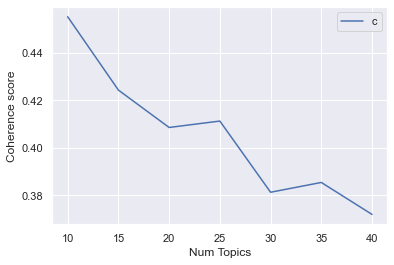

In [34]:
start=10; limit=41; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling